In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://raw.githubusercontent.com/amoreira2/Fin418/main/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
Data['Date']=pd.to_datetime(Data['Date'])
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })


# Trading Strategies

* A trading strategy is a procedure that maps any information known up to time t, into a set of trading instructions for time  $T>t$.

   - the mean-variance analysis we did so far was **not** a valid trading strategy: 
   - we used data of the whole sample to estimate the weights of our strategy and evaluated the strategy in the same sample



* It is very important that the trading strategy only uses information that is known at the time of the trade
* -- you obviously cannot trade on info that you don't know

* The weights of a trading strategy must either:
   * Add up to 1. So it describes what you do with your entire capital.
   * Or add up to 0. So the strategy is self-financing. For example, borrow 1 dollar at the risk-free rate and buy 1 dollar worth of the market portfolio
   * Every time you trade on the excess returns, you can think of the weights "adding up to zero", because it is a long-short portfolio.
   * In practice all strategies demand some capital as no bank allow us to borrow without putting some capital in, but these self financed strategies are quite convenient to work with as they are all in the "Excess Return Space" since they have zero cost. 

**Examples**

* Example of a VALID trading strategy: Every monday buy stocks that had positive news coverage during the weekend and sell stocks that had negative news coverage.

  * This is valid because you are trading after the information is known.

* Example of INVALID trading strategy: On Friday buy all the stocks that WILL have positive news coverage during the weekend, and sell all the stocks that WILL have negative coverage during the weekend.

   * This is Invalid because you are trading before the information is known.
   
* This might sound ridiculous. Obviously you cannot trade on the information that is not known at the time of the trade!


**Types of trading strategies**

- **Strategic allocation**: How you allocate across broad asset classes: Cash, Equities (US, Developed Markets, Emerging Markets), Government bonds (US, ...), Corporate bonds(US, ...), Commodities, Private equity, real assets (land,...)

    -  The strategy takes positions on broader asset classes. For example pension funds tend to follow a 70-30 split between equity and bonds
    -  An example is of this is the mean-variance anaylsis we did last few chapters.
    -  We will revisit this here but now making the analysis more tight
    -  Another example is RISK-PARITY which we will discuss later 
    

- **Timing**: Easier to think in terms of one risky asset and cash. The strategy basically goes in and out of an asset according to some model that forecasts time-variaiton either in returns of the risky asset realitve to cash or in it's riskness

    - You obvioulsy can time multiple things at the same time, but it is useful separation to help understand what the strategy is doing
    
- **Cross-sectional** (within asset class): This is about how you invest within an asset class. The "defaul" option is to do a market-cap weighted portfolio which we will discuss below. The cross-sectional strategies use some information to deviate from the market portfolio in the asset class

    - The are cross-sectional strategies everywhere: equities, gov bonds, corp bonds, futures, equity indexes, currencies, commodities, options, crypto currrencies
    - All these asset classes have lots of data and are naturally a good place to do quantitative investing
    - For this class we focus on equities

- Strategies can be discretionary: A team decides to place a trade based on their evaluation of information about a firm or the macro environment


- Strategies can be systematic: they can be codified. Explicit rule for the portfolio based on some hard data. Systematic trading strategies are often called **Quantitative**




## **Quantitative trading strategies**

* A quant trading strategy get some hard data about one or multiple assets and transform this data  into  portfolio weights

* So given data $Z_{t}$ ( potentially a very big vector), a quantitative trading strategy is a function that maps data into weights $X_{t+1}=f(Z_t)$


## **Our First Quantitative Strategy**

 
Here what we will do: do the mean-variance analysis assuming I am an investor that is doing this in real time

- so I will say the investor will start in 1973, 10 years after the beginning of the sample 
- simply use the past data to estimate the means and covariances,
- compute the weights and invest on the assets according to this strategy for the next month.
 
I will do that for the entire sample.
 
This will be valid because at no moment we use information that an investor would not have had available in real time. 

We will target an annual volatility of 15%

We will start by using just the first 10 years and evaluating on the rest of the sample as a warm up (because it is simpler)


Warm up

In [2]:
# construct excess returns from our data

Re=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')
Re.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 647 entries, 1963-02-28 to 2016-12-31
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MKTUS    647 non-null    float64
 1   BondUS   647 non-null    float64
 2   EM       647 non-null    float64
 3   MKTxUS   647 non-null    float64
 4   BondxUS  646 non-null    float64
dtypes: float64(5)
memory usage: 30.3 KB


In [3]:
# lets start by redoing our full sample analysis

# create a dataframe to store results
Results=pd.DataFrame([],index=[])
#Estimate moments using full sample

ERe=Re.mean()
CovRe=Re.cov()
# Set desired volatility and convert to monthly units
Targetvol=0.15/(12**0.5)


# construct weights and normalize them so the have desired volatility
X=np.linalg.inv(CovRe) @ ERe* (Targetvol/(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5)
#store results for full sample
Results.at['avgreturn','Fullsample']=X @ ERe*12
Results.at['volatility','Fullsample']=(X @ CovRe @ X*12)**0.5
Results.at['shaperatio','Fullsample']=(X @ ERe*12)/((X @ CovRe @ X*12)**0.5)

Results

,Fullsample
avgreturn,0.085055
volatility,0.150000
shaperatio,0.567030


In [4]:

#Estimate moments up to 1973
Endofsample=1973
ERe=Re[:str(Endofsample)].mean()
CovRe=Re[:str(Endofsample)].cov()

# construct weights and normalize them so the have desired volatility
X=np.linalg.inv(CovRe) @ ERe* (Targetvol/(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5)

# store results for estimation period
Results.at['avgreturn','Estimation_pre'+str(Endofsample)]=X @ ERe*12
Results.at['volatility','Estimation_pre'+str(Endofsample)]=(X @ CovRe @ X*12)**0.5
Results.at['shaperatio','Estimation_pre'+str(Endofsample)]=(X @ ERe*12)/((X @ CovRe @ X*12)**0.5)

# construct time series of returns for out of sample period
Rp=Re[str(Endofsample+1):] @ X

# store results for out of sample period
Results.at['avgreturn','test_pos'+str(Endofsample)]=Rp.mean()*12
Results.at['volatility','test_pos'+str(Endofsample)]=Rp.std()*12**0.5
Results.at['shaperatio','test_pos'+str(Endofsample)]=Rp.mean()*12/(Rp.std()*12**0.5)


Results

,Fullsample,Estimation_pre1973,test_pos1973
avgreturn,0.085055,0.102715,-0.014757
volatility,0.150000,0.150000,0.284975
shaperatio,0.567030,0.684767,-0.051783


- Look how bad this is
- The average excess return ends up negative!
- The volatility ends up as much twice as large

Why so bad? What is going on?

* We stopped in 1973. MAybe 10 years is not enough. 
* maybe we should split test sample and estimation sample more evenly? 
* what happens if we split right down the middle? Are the results better? Are they good enough?


A more sophisticated and also more realistic description of a trading strategy uses the concept of a rolling estimation sample

Basically you start in some date 1973, build you portfolio and hold it for a month, and each month that passes you re-estimate your weights and again hold the new portfolio for another month

So you are always using data up to month t and holding the position in date t+1.


## Garbage in, Garbage out

* we are plugging estimators for expected returns and the covariance matrix wihthout any evaluation if our procedure actually implements good estimators

* If our estimators are garbage, MV analysis will produce garbage

* Mean-variance optimization is EXTREMELY sensitive to the inputs
    1. Expected returns
    1. Covariance matrix: cross assets correlations and asset volatilities

* Importantly our estimators are extremely noisy--returns are very volatile

* assuming the underlying distribution is constant (big if), we need very long data set to reduce the uncertainty of our estimates for expected returns, and also to a lesser extent correlations and vols

### Estimation uncertainty

*  estimate the uncertainty regarding our average expected excess return estimates for each asset

*  show how the weights change as we change these estimates in a way that is consistent with the amount of uncertainty, i.e. those are alternative numbers that we could have estimated by change

*  show how sensitive the benefits of international diversification are

**Standard errors of average estimators**

* If observations are serially uncorrelated over time then the standard deviation of a sample average is simply

$$std\left(\sum_t^T\frac{R_t}{N}\right)=\frac{std(x_t)}{\sqrt{T}}$$


* This measures how uncertain we are about the sample mean

* For example, there is a 5% probability that the actual mean is $E[x_i]\leq\overline{R_t}-1.64{std(\overline{R_t})}$

* So $std(\overline{R_t})$ gives a measure of how close our estimate is likely to be to true expected value

* Lets compare the sample average and the sample average standard deviation for our assets

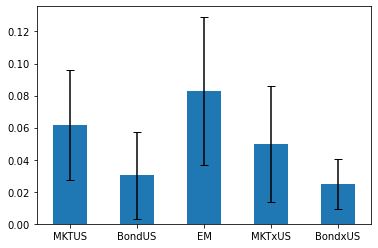

In [5]:
# First we get the total number of observations and store it as `T`
T=Re.shape[0]
# (1) standard deviation of the sample average of excess return for each asset
avg_std=(Re.std()/(T**0.5))*12

# (2) sample average of excess return for each asset
avg=Re.mean()*12


# report annualized and in percent
avg.plot.bar(yerr=avg_std*1.64,  capsize=4, rot=0);

- What happens if the sample was only 10 years?
- What happens if the assets is twice more volatile?
- What happens if you want to be be 99% sure to be right (instead of 68%)


## Sensitivity of optimal weights to uncertainty

- Lets revisit the classical financial advice that investors should have 60 in equities and 40 in bonds

- We will assume that the truth is 2 standard deviations below the mean for the US market

- We will them compare the expected return we expected to get, vs what we actually get


In [6]:


assets=['MKTUS','BondUS']

Weights_perturb=pd.DataFrame([],index=assets)
ERe=Re[assets].mean()
CovRe=Re[assets].cov()
T=Re.shape[0]

asset='MKTUS'
pertubation=2
mu=Re[asset].mean()
mu_std=Re[asset].std()/T**0.5
# I am creating a copy of the average return vector so I can pertubate it below 
ER_perturb=ERe.copy()
# so this will be the pertubated mean for asset MKTUS, which will represent the actual truth
ER_perturb[asset]=mu-pertubation*mu_std

# mve for sample mean
Weights_perturb.loc[:,'estimate'] =np.linalg.inv(CovRe) @ ERe
# mve for perturbed mean
Weights_perturb.loc[:,'truth'] =np.linalg.inv(CovRe) @ ER_perturb



We can then normalize the weights to achieve some desired volatility or that they add up to 1

Here I will simply make them add up to 1

In [7]:

#normalizing weights so they add up to 1
Weights_perturb=Weights_perturb/Weights_perturb.sum()
Weights_perturb

,estimate,truth
MKTUS,0.581072,0.272283
BondUS,0.418928,0.727717


- the `estimate` weights tell us the optimal weights given the data we saw
- the `truth` tell us the optimal weights given the true moments


We can now comapre the expected return that we expected to get (given the data) and the one we actually get (given the truth)


In [8]:
# Calculate the expression first
expected_data = Weights_perturb.loc[:,'estimate'] @ ERe * 12
# Then use the result in the f-string
print(f'Expected to get given data: {expected_data}')
# Calculate the expression first
actual_data = Weights_perturb.loc[:,'estimate'] @ ER_perturb * 12

# Then use the result in the f-string
print(f'Will actually get given the truth:{actual_data}')



Expected to get given data: 0.04852462499115857
Will actually get given the truth:0.02432653824907584


* What perturbation are we are exposed to?  that they true mean is higher or lower than expected?
* How does it depend on the weights?
* Why perturbing one assets leads to changes in the other assets? What this cross-sensitivity depends on?
* What do you think will happen if we do this with individual stocks instead? Why?
* what do you think would happen by adding crypto to this problem, say bitcoin?
* similar problems happen in estimating the correlations specially as the number of assets grow large


## Covariance estimation with a large cross-sectional of assets


* Lets import the universe of US equities
* The sample is 15 years. 

In [ ]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
###################
# Connect to WRDS. #
# You will be required to put your name and password if you have it
###################
conn=wrds.Connection() 

###################
# This below dowloads from the server the data that we want #
###################
crsp_m = conn.raw_sql("""
                      select a.permno, a.date, b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc,a.retx
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2005' and '12/31/2020'
                      and b.exchcd between 1 and 3
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

# this saves it
#crsp_m.to_pickle('../../assets/data/crspm2005_2020.pkl')
# variables downloaded

# 1. Permno-- are unique indentifier to a security 
# (for exmaple a stock that has multiple types of stocks will have multiple permnos)

# 2. shrco is the type of share: common share, ADR, ETF, ....
# we will focus on common shares

# 3. exchcd is the code of the exchange where the stock was originally listed
# we will focus on stock listed in the 3 major stock exchanges ( basically the whole market)

# 4. ret,retx, shrout,  prc, are the stock return, the stock return excluding dividends, number of shares outstanding, and price

# 5. date is the trading date of the return



WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


____
*If you don't want to deal with that you can simply get the data by running the code below*

In [9]:

crsp_m=pd.read_pickle('https://github.com/amoreira2/Fin418/blob/main/assets/data/crspm2005_2020.pkl?raw=true')

In [10]:
from pandas.tseries.offsets import MonthEnd
# keep the variables we need
crsp=crsp_m[['permno','date','ret']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

In [11]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763626 entries, 0 to 763625
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   permno  763626 non-null  int32         
 1   date    763626 non-null  datetime64[ns]
 2   ret     759919 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 14.6 MB


In [12]:
# there are about 4 thousand stocks in the sample on average
print(759919/(15*12))

# but overall 8 thousand stocks traded in the sample
crsp.permno.unique().shape[0]

# why is that?

4221.772222222222


8386

- How many parameters do we need to estimate for a covariance matrix across these 8 thousand stocks?
- Do we even have enough observations for that?
- What will happen with our covariance matrix?



Lets just try and see what happens

We will do brute force
1. Set permno and date as indexes
1. unstack so we have the different firms in the columns and the dates in the rows


In [13]:
crsp.set_index(['permno','date'],inplace=True)

crsp=crsp.unstack('permno')
crsp

ret                                                    \
permno         10001     10002     10012     10025     10026     10028   
date                                                                     
2005-01-31 -0.040580 -0.132466 -0.320388  0.277966 -0.015909 -0.063830   
2005-02-28 -0.045166 -0.033255 -0.285714  0.082228 -0.021554 -0.034091   
2005-03-31  0.124822 -0.013081 -0.080000 -0.031863 -0.005401  0.019608   
2005-04-30 -0.074684 -0.066700 -0.195652 -0.058734  0.045270 -0.094231   
2005-05-31  0.219030  0.046586 -0.243243 -0.073158  0.008376  0.027601   
...              ...       ...       ...       ...       ...       ...   
2020-08-31       NaN       NaN       NaN       NaN  0.104118 -0.082742   
2020-09-30       NaN       NaN       NaN       NaN -0.036668  0.105670   
2020-10-31       NaN       NaN       NaN       NaN  0.039727 -0.058275   
2020-11-30       NaN       NaN       NaN       NaN  0.072435  0.143564   
2020-12-31       NaN       NaN       NaN       NaN  0.072598  0.125541   

                                                    ...                      \
permno         10032     10042     10044     10051  ...     93423     93426   
date                                                ...                       
2005-01-31 -0.114527 -0.195312  0.130375 -0.111111  ...       NaN       NaN   
2005-02-28 -0.079861 -0.213592  0.297917 -0.155556  ...       NaN       NaN   
2005-03-31  0.085849 -0.111111  0.209575 -0.021382  ...       NaN       NaN   
2005-04-30  0.052129 -0.069444 -0.197000 -0.018487  ...       NaN       NaN   
2005-05-31  0.137077  0.104478  0.189298 -0.126712  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2020-08-31  0.023960       NaN -0.018072  0.131730  ...  0.249569 -0.021218   
2020-09-30 -0.071513       NaN -0.177914 -0.199393  ... -0.065808  0.016459   
2020-10-31 -0.015432       NaN  0.000000  0.104298  ...  0.065025 -0.056477   
2020-11-30  0.074346       NaN  0.593284  0.298798  ...  0.421369  0.224362   
2020-12-31  0.046848       NaN -0.051522 -0.030851  ...  0.109665  0.076239   

                                                                    
permno     93428 93429 93430 93432 93433     93434 93435     93436  
date                                                                
2005-01-31   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-02-28   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-03-31   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-04-30   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-05-31   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
...          ...   ...   ...   ...   ...       ...   ...       ...  
2020-08-31   NaN   NaN   NaN   NaN   NaN  0.008584   NaN  0.741452  
2020-09-30   NaN   NaN   NaN   NaN   NaN  0.055319   NaN -0.139087  
2020-10-31   NaN   NaN   NaN   NaN   NaN -0.080645   NaN -0.095499  
2020-11-30   NaN   NaN   NaN   NaN   NaN  0.144737   NaN  0.462736  
2020-12-31   NaN   NaN   NaN   NaN   NaN  0.122605   NaN  0.243252  

[192 rows x 8386 columns]

What do we do with the many nans?

Do we drop all dates that don't have complete rows?

How many months are we going to be left with?

Lets just do it


In [14]:
cov=crsp.cov()
cov

ret                                                    \
permno         10001     10002     10012     10025     10026     10028   
    permno                                                               
ret 10001   0.007798 -0.000774  0.002537  0.000522  0.000039  0.002555   
    10002  -0.000774  0.024677  0.002167  0.001650  0.002524  0.003879   
    10012   0.002537  0.002167  0.006135 -0.006106  0.000942  0.000476   
    10025   0.000522  0.001650 -0.006106  0.016193  0.001591  0.001028   
    10026   0.000039  0.002524  0.000942  0.001591  0.003983  0.000821   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.005004  0.002269       NaN -0.003024 -0.004135 -0.009098   
    93433  -0.001406 -0.007665       NaN -0.014701 -0.004120 -0.002850   
    93434  -0.000266  0.001515       NaN  0.000819  0.000071  0.002819   
    93435   0.000278 -0.009037       NaN  0.005475  0.001340 -0.000840   
    93436  -0.001426 -0.005984       NaN -0.002047  0.001451  0.000558   

                                                    ...                      \
permno         10032     10042     10044     10051  ...     93423     93426   
    permno                                          ...                       
ret 10001   0.000775 -0.001050  0.000194  0.000912  ... -0.000404 -0.000114   
    10002  -0.000004 -0.000807  0.000077  0.000552  ... -0.004404 -0.002795   
    10012   0.004454  0.001930 -0.002265  0.006284  ...       NaN       NaN   
    10025   0.003443  0.000223  0.002208  0.001293  ...  0.001431  0.001461   
    10026   0.002423 -0.000481  0.001266  0.002258  ...  0.003223  0.001250   
...              ...       ...       ...       ...  ...       ...       ...   
    93432  -0.007766       NaN  0.001334  0.001569  ... -0.006456 -0.001053   
    93433   0.006160       NaN -0.012879 -0.001388  ... -0.003570 -0.013165   
    93434  -0.000537       NaN  0.000654 -0.001071  ...  0.000127  0.000070   
    93435   0.004911       NaN -0.000609 -0.001579  ...  0.012086  0.007676   
    93436   0.003966       NaN  0.002036  0.004171  ...  0.005557  0.001712   

                                                                        \
permno         93428     93429     93430     93432     93433     93434   
    permno                                                               
ret 10001  -0.001576 -0.000129  0.000675 -0.005004 -0.001406 -0.000266   
    10002  -0.010441 -0.001337 -0.017943  0.002269 -0.007665  0.001515   
    10012        NaN       NaN       NaN       NaN       NaN       NaN   
    10025   0.002456  0.001263  0.010778 -0.003024 -0.014701  0.000819   
    10026   0.001479  0.000853  0.007287 -0.004135 -0.004120  0.000071   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.001264 -0.000187 -0.003197  0.022076 -0.009247  0.006736   
    93433   0.001492 -0.000840  0.018457 -0.009247  1.276334  0.001169   
    93434   0.000858 -0.000743 -0.009930  0.006736  0.001169  0.015841   
    93435  -0.004608  0.007259  0.019851 -0.000768  0.024445  0.004483   
    93436   0.014019  0.001869  0.014379 -0.009019  0.032895  0.000147   

                                
permno         93435     93436  
    permno                      
ret 10001   0.000278 -0.001426  
    10002  -0.009037 -0.005984  
    10012        NaN       NaN  
    10025   0.005475 -0.002047  
    10026   0.001340  0.001451  
...              ...       ...  
    93432  -0.000768 -0.009019  
    93433   0.024445  0.032895  
    93434   0.004483  0.000147  
    93435   0.114267  0.012217  
    93436   0.012217  0.034449  

[8386 rows x 8386 columns]

- So we got something. How do you think pandas solved the issue.
- Did it really solve?
- How many parameters were estimated?
- How many observations do we have?

In [15]:
print((cov.shape[0]*cov.shape[1]-cov.shape[1])/2+cov.shape[1])


((cov.shape[0]*cov.shape[1]-cov.shape[1])/2+cov.shape[1])/759919


35166691.0


46.27689398475364

- We have about 800 thousand month-firms observations

- But we need to estimate 35 million parameters!

- That is 46 more parameters then data points!

- Obviously these estimates are total garbage

- Typically we want MANY more observations than parameters!

## What to do?


1. Adopt trading strategies that use data more parsimoniously, essentially shrinking lots of the estimates towards some common value
    - **Minimum** variance investing: assume all assets have the same expected return
    - Risk-parity: Assume assets have zero correlation and all assets have the same Sharpe-Ratio
    - Market-cap weights: Theory tell us that this portfolios must be pretty good (CAPM logic)
    - etc
    
1. Use factor models of risk 
    - factor models of risk impose structure in estimating large co-variance matrixes (how many parameters do you need to estimate for the covariance matrix of 5000 stocks?)

1. Use more robust estimators: basically you "shrink" your estimates to some reasonable value based on some simple model
    - for example you can adjust the sample mean towards the one implied by the CAPM
    
    
1. Using short data samples to produce estimates for mean-variance inputs is very dangerous. It leads to pro-cyclical portfolio. When past returns have been high, current prices are high, implying that future returns may actually be low. Thus, using a past data sample to estimate a mean produces a high estimate right when future returns are likely to be low. 


The critical insight of Mean-Variance investing is **Diversification**

One wants to construct portfolios that harvest this diversification



## Shrinking the Covariance Matrix

One approach that is quite intuitive is to shrink all the variances to a common value and all the covariance terms to a common value.

The idea comes from Bayesian thinking: before you look at the data you think all the assets are the same.

So you tilt towards this common value depending of the strenght of your prior

of course you have to tilt a little bit, not too much, otherwise you are not letting the data speak

$$\hat{\Sigma}_s=h\Sigma_s+(1-h)\hat{\Sigma}$$

A empirically drive way to choose this $\Sigma_s$ is to see the covariance terms to the average of the covariance terms and the variance terms to the average of the variance terms 

In [22]:
average_diagonal = np.nanmean(np.diag(cov))
print(average_diagonal)



off_diagonal_terms = cov.values[np.triu_indices_from(cov, k=1)]

average_off_diagonal = np.nanmean(off_diagonal_terms)

print(average_off_diagonal)

# Create a copy of the covariance matrix
cov_shrink = cov.copy()
# Set the UP off-diagonal terms to the average_off_diagonal
cov_shrink.values[np.triu_indices_from(cov_shrink, k=1)] = average_off_diagonal

# Set the LOWER off-diagonal terms to the average_off_diagonal
cov_shrink.values[np.tril_indices_from(cov_shrink, k=-1)] = average_off_diagonal
# Set the diagonal terms to the average_diagonal
np.fill_diagonal(cov_shrink.values, average_diagonal)
# note that now the covariance matrix is invertable



0.043679075680530866
0.0035243332461513386


In [23]:
cov_shrink

ret                                                    \
permno         10001     10002     10012     10025     10026     10028   
    permno                                                               
ret 10001   0.043679  0.003524  0.003524  0.003524  0.003524  0.003524   
    10002   0.003524  0.043679  0.003524  0.003524  0.003524  0.003524   
    10012   0.003524  0.003524  0.043679  0.003524  0.003524  0.003524   
    10025   0.003524  0.003524  0.003524  0.043679  0.003524  0.003524   
    10026   0.003524  0.003524  0.003524  0.003524  0.043679  0.003524   
...              ...       ...       ...       ...       ...       ...   
    93432   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    93433   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    93434   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    93435   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    93436   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   

                                                    ...                      \
permno         10032     10042     10044     10051  ...     93423     93426   
    permno                                          ...                       
ret 10001   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    10002   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    10012   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    10025   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    10026   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
...              ...       ...       ...       ...  ...       ...       ...   
    93432   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    93433   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    93434   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    93435   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   
    93436   0.003524  0.003524  0.003524  0.003524  ...  0.003524  0.003524   

                                                                        \
permno         93428     93429     93430     93432     93433     93434   
    permno                                                               
ret 10001   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    10002   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    10012   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    10025   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    10026   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
...              ...       ...       ...       ...       ...       ...   
    93432   0.003524  0.003524  0.003524  0.043679  0.003524  0.003524   
    93433   0.003524  0.003524  0.003524  0.003524  0.043679  0.003524   
    93434   0.003524  0.003524  0.003524  0.003524  0.003524  0.043679   
    93435   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    93436   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   

                                
permno         93435     93436  
    permno                      
ret 10001   0.003524  0.003524  
    10002   0.003524  0.003524  
    10012   0.003524  0.003524  
    10025   0.003524  0.003524  
    10026   0.003524  0.003524  
...              ...       ...  
    93432   0.003524  0.003524  
    93433   0.003524  0.003524  
    93434   0.003524  0.003524  
    93435   0.043679  0.003524  
    93436   0.003524  0.043679  

[8386 rows x 8386 columns]

In [24]:
# calculate the inverse of the covariance matrix
np.linalg.inv(cov_shrink)

array([[ 2.49006930e+01, -2.96564148e-03, -2.96564148e-03, ...,
        -2.96564148e-03, -2.96564148e-03, -2.96564148e-03],
       [-2.96564148e-03,  2.49006930e+01, -2.96564148e-03, ...,
        -2.96564148e-03, -2.96564148e-03, -2.96564148e-03],
       [-2.96564148e-03, -2.96564148e-03,  2.49006930e+01, ...,
        -2.96564148e-03, -2.96564148e-03, -2.96564148e-03],
       ...,
       [-2.96564148e-03, -2.96564148e-03, -2.96564148e-03, ...,
         2.49006930e+01, -2.96564148e-03, -2.96564148e-03],
       [-2.96564148e-03, -2.96564148e-03, -2.96564148e-03, ...,
        -2.96564148e-03,  2.49006930e+01, -2.96564148e-03],
       [-2.96564148e-03, -2.96564148e-03, -2.96564148e-03, ...,
        -2.96564148e-03, -2.96564148e-03,  2.49006930e+01]])

In [25]:
# calculate the inverse of the covariance matrix
np.linalg.inv(cov)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [26]:
# this is partly happenign because some terms are nans--these assets simply do not overlap in time
cov

ret                                                    \
permno         10001     10002     10012     10025     10026     10028   
    permno                                                               
ret 10001   0.007798 -0.000774  0.002537  0.000522  0.000039  0.002555   
    10002  -0.000774  0.024677  0.002167  0.001650  0.002524  0.003879   
    10012   0.002537  0.002167  0.006135 -0.006106  0.000942  0.000476   
    10025   0.000522  0.001650 -0.006106  0.016193  0.001591  0.001028   
    10026   0.000039  0.002524  0.000942  0.001591  0.003983  0.000821   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.005004  0.002269       NaN -0.003024 -0.004135 -0.009098   
    93433  -0.001406 -0.007665       NaN -0.014701 -0.004120 -0.002850   
    93434  -0.000266  0.001515       NaN  0.000819  0.000071  0.002819   
    93435   0.000278 -0.009037       NaN  0.005475  0.001340 -0.000840   
    93436  -0.001426 -0.005984       NaN -0.002047  0.001451  0.000558   

                                                    ...                      \
permno         10032     10042     10044     10051  ...     93423     93426   
    permno                                          ...                       
ret 10001   0.000775 -0.001050  0.000194  0.000912  ... -0.000404 -0.000114   
    10002  -0.000004 -0.000807  0.000077  0.000552  ... -0.004404 -0.002795   
    10012   0.004454  0.001930 -0.002265  0.006284  ...       NaN       NaN   
    10025   0.003443  0.000223  0.002208  0.001293  ...  0.001431  0.001461   
    10026   0.002423 -0.000481  0.001266  0.002258  ...  0.003223  0.001250   
...              ...       ...       ...       ...  ...       ...       ...   
    93432  -0.007766       NaN  0.001334  0.001569  ... -0.006456 -0.001053   
    93433   0.006160       NaN -0.012879 -0.001388  ... -0.003570 -0.013165   
    93434  -0.000537       NaN  0.000654 -0.001071  ...  0.000127  0.000070   
    93435   0.004911       NaN -0.000609 -0.001579  ...  0.012086  0.007676   
    93436   0.003966       NaN  0.002036  0.004171  ...  0.005557  0.001712   

                                                                        \
permno         93428     93429     93430     93432     93433     93434   
    permno                                                               
ret 10001  -0.001576 -0.000129  0.000675 -0.005004 -0.001406 -0.000266   
    10002  -0.010441 -0.001337 -0.017943  0.002269 -0.007665  0.001515   
    10012        NaN       NaN       NaN       NaN       NaN       NaN   
    10025   0.002456  0.001263  0.010778 -0.003024 -0.014701  0.000819   
    10026   0.001479  0.000853  0.007287 -0.004135 -0.004120  0.000071   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.001264 -0.000187 -0.003197  0.022076 -0.009247  0.006736   
    93433   0.001492 -0.000840  0.018457 -0.009247  1.276334  0.001169   
    93434   0.000858 -0.000743 -0.009930  0.006736  0.001169  0.015841   
    93435  -0.004608  0.007259  0.019851 -0.000768  0.024445  0.004483   
    93436   0.014019  0.001869  0.014379 -0.009019  0.032895  0.000147   

                                
permno         93435     93436  
    permno                      
ret 10001   0.000278 -0.001426  
    10002  -0.009037 -0.005984  
    10012        NaN       NaN  
    10025   0.005475 -0.002047  
    10026   0.001340  0.001451  
...              ...       ...  
    93432  -0.000768 -0.009019  
    93433   0.024445  0.032895  
    93434   0.004483  0.000147  
    93435   0.114267  0.012217  
    93436   0.012217  0.034449  

[8386 rows x 8386 columns]

In [27]:
# but that is not the only problem. The covariance matrix is not invertable because it is singular. 
# to see this we will fill the nans with the average off diagonal term
cov_nonnans = cov.fillna(average_off_diagonal)
cov_nonnans

ret                                                    \
permno         10001     10002     10012     10025     10026     10028   
    permno                                                               
ret 10001   0.007798 -0.000774  0.002537  0.000522  0.000039  0.002555   
    10002  -0.000774  0.024677  0.002167  0.001650  0.002524  0.003879   
    10012   0.002537  0.002167  0.006135 -0.006106  0.000942  0.000476   
    10025   0.000522  0.001650 -0.006106  0.016193  0.001591  0.001028   
    10026   0.000039  0.002524  0.000942  0.001591  0.003983  0.000821   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.005004  0.002269  0.003524 -0.003024 -0.004135 -0.009098   
    93433  -0.001406 -0.007665  0.003524 -0.014701 -0.004120 -0.002850   
    93434  -0.000266  0.001515  0.003524  0.000819  0.000071  0.002819   
    93435   0.000278 -0.009037  0.003524  0.005475  0.001340 -0.000840   
    93436  -0.001426 -0.005984  0.003524 -0.002047  0.001451  0.000558   

                                                    ...                      \
permno         10032     10042     10044     10051  ...     93423     93426   
    permno                                          ...                       
ret 10001   0.000775 -0.001050  0.000194  0.000912  ... -0.000404 -0.000114   
    10002  -0.000004 -0.000807  0.000077  0.000552  ... -0.004404 -0.002795   
    10012   0.004454  0.001930 -0.002265  0.006284  ...  0.003524  0.003524   
    10025   0.003443  0.000223  0.002208  0.001293  ...  0.001431  0.001461   
    10026   0.002423 -0.000481  0.001266  0.002258  ...  0.003223  0.001250   
...              ...       ...       ...       ...  ...       ...       ...   
    93432  -0.007766  0.003524  0.001334  0.001569  ... -0.006456 -0.001053   
    93433   0.006160  0.003524 -0.012879 -0.001388  ... -0.003570 -0.013165   
    93434  -0.000537  0.003524  0.000654 -0.001071  ...  0.000127  0.000070   
    93435   0.004911  0.003524 -0.000609 -0.001579  ...  0.012086  0.007676   
    93436   0.003966  0.003524  0.002036  0.004171  ...  0.005557  0.001712   

                                                                        \
permno         93428     93429     93430     93432     93433     93434   
    permno                                                               
ret 10001  -0.001576 -0.000129  0.000675 -0.005004 -0.001406 -0.000266   
    10002  -0.010441 -0.001337 -0.017943  0.002269 -0.007665  0.001515   
    10012   0.003524  0.003524  0.003524  0.003524  0.003524  0.003524   
    10025   0.002456  0.001263  0.010778 -0.003024 -0.014701  0.000819   
    10026   0.001479  0.000853  0.007287 -0.004135 -0.004120  0.000071   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.001264 -0.000187 -0.003197  0.022076 -0.009247  0.006736   
    93433   0.001492 -0.000840  0.018457 -0.009247  1.276334  0.001169   
    93434   0.000858 -0.000743 -0.009930  0.006736  0.001169  0.015841   
    93435  -0.004608  0.007259  0.019851 -0.000768  0.024445  0.004483   
    93436   0.014019  0.001869  0.014379 -0.009019  0.032895  0.000147   

                                
permno         93435     93436  
    permno                      
ret 10001   0.000278 -0.001426  
    10002  -0.009037 -0.005984  
    10012   0.003524  0.003524  
    10025   0.005475 -0.002047  
    10026   0.001340  0.001451  
...              ...       ...  
    93432  -0.000768 -0.009019  
    93433   0.024445  0.032895  
    93434   0.004483  0.000147  
    93435   0.114267  0.012217  
    93436   0.012217  0.034449  

[8386 rows x 8386 columns]

In [28]:
# still not invertable!
np.linalg.inv(cov_nonnans)

LinAlgError: Singular matrix

In [29]:
# now lets Shrink the sampel covariance matrix to our "prior"
# this works even with quite a small shrinkage parameter
h=0.01
cov_shrinked=cov_shrink*h+(1-h)*cov_nonnans
np.linalg.inv(cov_shrink)




array([[ 2.49006930e+01, -2.96564148e-03, -2.96564148e-03, ...,
        -2.96564148e-03, -2.96564148e-03, -2.96564148e-03],
       [-2.96564148e-03,  2.49006930e+01, -2.96564148e-03, ...,
        -2.96564148e-03, -2.96564148e-03, -2.96564148e-03],
       [-2.96564148e-03, -2.96564148e-03,  2.49006930e+01, ...,
        -2.96564148e-03, -2.96564148e-03, -2.96564148e-03],
       ...,
       [-2.96564148e-03, -2.96564148e-03, -2.96564148e-03, ...,
         2.49006930e+01, -2.96564148e-03, -2.96564148e-03],
       [-2.96564148e-03, -2.96564148e-03, -2.96564148e-03, ...,
        -2.96564148e-03,  2.49006930e+01, -2.96564148e-03],
       [-2.96564148e-03, -2.96564148e-03, -2.96564148e-03, ...,
        -2.96564148e-03, -2.96564148e-03,  2.49006930e+01]])

Which shrinkage parameter to use is a "data-driven" question

You have to see what works
